<a href="https://colab.research.google.com/github/hye2ryoung/DA_Project/blob/main/%E1%84%90%E1%85%B5%E1%86%B7%E1%84%91%E1%85%B3%E1%84%85%E1%85%A9%E1%84%8C%E1%85%A6%E1%86%A8%E1%84%90%E1%85%B3_%E1%84%80%E1%85%A9%E1%84%80%E1%85%A2%E1%86%A8_%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A1%E1%86%AF_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_%E1%84%86%E1%85%B5%E1%86%BE_%E1%84%87%E1%85%A1%E1%86%BC%E1%84%8C%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zb-da3-competition/BankChurners_.csv


# 목차

1. [서론](#서론)
2. [Process01](#Data-전처리)
   - [데이터 EDA](#이상치-제거)
   - [데이터 전처리](#데이터-전처리)
   - [Feature Selection](#Feature-Selection)
3. [process02](#심층분석)
   - [상관분석](#상관분석)
   - [저위험 고객군 특징](#저위험-고객군-특징)
   - [Numeric 변수](#Numeric-변수)
   - [Categorical 변수](#Categorical-변수)
4. [process03](#ML모델링)
   - [모델링을 위한 데이터준비](#ML모델링)
   - [모델 학습 및 평가](#모델-학습-및-평가)
   - [하이퍼파라미터 튜닝](#Hyper-parameter-튜닝)
   - [중요변수 파악](#중요-변수-파악)
   - [SHAP Value](#SHAP-Value)
   - [Rule Extraction](#Rule-Extraction)
5. [인사이트](#인사이트)


### 데이터 Import

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore", message="The default of observed=False is deprecated")

df = pd.read_csv('/kaggle/input/zb-da3-competition/BankChurners_.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# 서론


▶위험군 분류 : CardCategory가 Blue,Silver 고객 추출뒤 Credit Limit으로 정렬하여 상위 10%,하위 10%로 고위험군,저위험군 분류

▶ 고위험군 고객의 이탈 예측 이유 :  

1)수익성 향상: 고위험군 고객이 이탈하지 않으면 카드회사는 이자 수익을 지속적으로 얻을 수 있습니다. 고위험군 고객은 상대적으로 높은 이자율을 적용받는 경우가 많기 때문에 이들의 유지가 수익성에 긍정적인 영향을 미칩니다.

2)고객 관계 유지: 이탈을 막음으로써 고객과의 장기적인 관계를 유지할 수 있습니다. 이는 고객 충성도를 높이고, 향후 다른 금융 상품이나 서비스를 제공할 기회를 늘려줍니다.

3)리스크 관리: 고위험군 고객의 이탈을 줄이면 채무불이행의 위험을 더 잘 관리할 수 있습니다. 지속적인 모니터링과 지원을 통해 이들이 채무를 원활히 상환할 수 있도록 돕는 것이 중요합니다.

4)데이터 및 인사이트 축적: 고위험군 고객을 유지하면서 다양한 데이터를 축적할 수 있습니다. 이러한 데이터는 향후 리스크 관리 및 고객 맞춤형 서비스 개발에 중요한 인사이트를 제공합니다.



---
### Data 전처리

수집된 데이터의 기본 정보들을 확인

(1) Data shape(형태) 확인

(2) Data type 확인

(3) Null값 확인 (※ 빈 값의 Data)

(4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)

In [ ]:
# 21개 컬럼
# 1만명의 고객 정보
df.shape

(10127, 21)

In [ ]:
# 컬럼 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [ ]:
# null 없음
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [ ]:
#기초 통계정보
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [ ]:
df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,739177606.0,36903783.0,708082083.0,713036770.0,717926358.0,773143533.0,828343083.0
Customer_Age,10127.0,46.0,8.0,26.0,41.0,46.0,52.0,73.0
Dependent_count,10127.0,2.0,1.0,0.0,1.0,2.0,3.0,5.0
Months_on_book,10127.0,36.0,8.0,13.0,31.0,36.0,40.0,56.0
Total_Relationship_Count,10127.0,4.0,2.0,1.0,3.0,4.0,5.0,6.0
Months_Inactive_12_mon,10127.0,2.0,1.0,0.0,2.0,2.0,3.0,6.0
Contacts_Count_12_mon,10127.0,2.0,1.0,0.0,2.0,2.0,3.0,6.0
Credit_Limit,10127.0,8632.0,9089.0,1438.0,2555.0,4549.0,11068.0,34516.0
Total_Revolving_Bal,10127.0,1163.0,815.0,0.0,359.0,1276.0,1784.0,2517.0
Avg_Open_To_Buy,10127.0,7469.0,9091.0,3.0,1324.0,3474.0,9859.0,34516.0


In [ ]:
df.describe(include='object').round().T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


폰트 import

In [ ]:
# 한글 폰트 설치
# 데이터, 라이브러리 불러오기 & 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf




The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 54 not upgraded.
Need to get 9599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Err:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3
  Temporary failure resolving 'archive.ubuntu.com'
E: Failed to fetch http://archive.ubuntu.com/ubuntu/pool/universe/f/fonts-nanum/fonts-nanum_20180306-3_all.deb  Temporary failure resolving 'archive.ubuntu.com'
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/ut

In [ ]:
# 중복된 행 확인
duplicate_rows = df[df['CLIENTNUM'].duplicated()]
duplicate_rows

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio


In [ ]:
df[df['Income_Category']=='Unknown']

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
19,709327383,Existing Customer,45,F,2,Graduate,Married,Unknown,Blue,37,...,1,2,14470.0,1157,13313.0,0.966,1207,21,0.909,0.080
28,718813833,Existing Customer,44,F,3,Uneducated,Single,Unknown,Blue,34,...,2,2,10100.0,0,10100.0,0.525,1052,18,1.571,0.000
39,708300483,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,...,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077
44,720572508,Existing Customer,38,F,4,Graduate,Single,Unknown,Blue,28,...,3,3,9830.0,2055,7775.0,0.977,1042,23,0.917,0.209
58,711427458,Existing Customer,44,F,5,Graduate,Married,Unknown,Blue,35,...,1,2,6273.0,978,5295.0,2.275,1359,25,1.083,0.156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10021,711149133,Attrited Customer,30,F,1,Graduate,Married,Unknown,Blue,18,...,1,4,4377.0,2517,1860.0,0.941,8759,74,0.609,0.575
10040,714677583,Attrited Customer,50,F,3,Doctorate,Single,Unknown,Blue,36,...,3,3,5173.0,0,5173.0,0.912,8757,68,0.789,0.000
10083,718170033,Existing Customer,42,F,4,Uneducated,Married,Unknown,Blue,23,...,1,2,8348.0,0,8348.0,0.695,15905,111,0.708,0.000
10092,713437008,Attrited Customer,40,F,3,Graduate,Married,Unknown,Blue,25,...,2,3,6888.0,1878,5010.0,1.059,9038,64,0.829,0.273


In [ ]:
# 총 거래량 대비 리볼빙 비율
# 채무비율이 높을수록 리스크가 높다고 판단
df_revolving_rate = df.copy()
df_revolving_rate['RevolvingRatio'] = round((df['Total_Revolving_Bal'] / df['Total_Trans_Amt'])*100,1)
df_revolving_rate

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,RevolvingRatio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,67.9
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,66.9
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,214.9
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,12.0
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,24.9
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.0
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.0


# 데이터 전처리

In [ ]:
# 총 거래량 대비 리볼빙 비율
# 채무비율이 높을수록 리스크가 높다고 판단
# RevolvingRatio : 채무비율
df_revolving_rate = df.copy()
df_revolving_rate['Revolving_Ratio'] = round((df['Total_Revolving_Bal'] / df['Total_Trans_Amt'])*100,1)
df_revolving_rate

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Revolving_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,67.9
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,66.9
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,214.9
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,12.0
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,24.9
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.0
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.0


In [ ]:
# 카드카테고리가 Blue,Silver만 추출 = 채무위험이 있다는 의미로 판단
df_risk_classification = df_revolving_rate[(df_revolving_rate['Card_Category'] == 'Blue') | (df_revolving_rate['Card_Category'] == 'Silver')]
df_risk_classification.value_counts('Card_Category')

Card_Category
Blue      9436
Silver     555
Name: count, dtype: int64

In [ ]:
df_risk_classification.sort_values('Credit_Limit')
# 10% 및 90% 퍼센타일을 포함하여 describe() 사용
print(df_risk_classification['Credit_Limit'].describe(percentiles=[0.10, 0.90]))

count     9991.000000
mean      8358.905725
std       8785.982906
min       1438.300000
10%       1755.000000
50%       4442.000000
90%      21877.000000
max      34516.000000
Name: Credit_Limit, dtype: float64


상위 하위 각각 10%씩 할당해서 리스크레벨 부여

In [ ]:
# 10% 및 90%의 퍼센타일 값을 구함
lower_quantile = df_risk_classification['Credit_Limit'].quantile(0.10)
upper_quantile = df_risk_classification['Credit_Limit'].quantile(0.90)

# 데이터의 최소값과 최대값을 구함
min_value = df_risk_classification['Credit_Limit'].min()
max_value = df_risk_classification['Credit_Limit'].max()

# 조건에 따라 'Revolving_Group' 열을 생성
df_risk_classification.loc[:, 'Risk_Category'] = pd.cut(df_risk_classification['Credit_Limit'],
                                         bins=[min_value, lower_quantile, upper_quantile, max_value],
                                         labels=['1_High', '2_Middle', '3_Low'],
                                         include_lowest=True)


# 결과 확인
print(df_risk_classification[['CLIENTNUM','Attrition_Flag','Risk_Category']])


       CLIENTNUM     Attrition_Flag Risk_Category
0      768805383  Existing Customer      2_Middle
1      818770008  Existing Customer      2_Middle
2      713982108  Existing Customer      2_Middle
3      769911858  Existing Customer      2_Middle
4      709106358  Existing Customer      2_Middle
...          ...                ...           ...
10122  772366833  Existing Customer      2_Middle
10123  710638233  Attrited Customer      2_Middle
10124  716506083  Attrited Customer      2_Middle
10125  717406983  Attrited Customer      2_Middle
10126  714337233  Attrited Customer      2_Middle

[9991 rows x 3 columns]


/tmp/ipykernel_18/2997524113.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_classification.loc[:, 'Risk_Category'] = pd.cut(df_risk_classification['Credit_Limit'],


In [ ]:
# 신용한도가 작은 고객들에게 High가 할당된것을 확인
#df_risk_classification.sort_values('Credit_Limit')
df_risk_classification[['CLIENTNUM','Credit_Limit','Risk_Category']].sort_values('Credit_Limit')

,CLIENTNUM,Credit_Limit,Risk_Category
5028,778905033,1438.3,1_High
8079,712300683,1438.3,1_High
4097,710197308,1438.3,1_High
8076,771594783,1438.3,1_High
4113,720479058,1438.3,1_High
...,...,...,...
3867,721252683,34516.0,3_Low
9456,789289383,34516.0,3_Low
7677,708273858,34516.0,3_Low
2846,711835758,34516.0,3_Low


In [ ]:
# 카테고리별 개수 계산
value_counts = df_risk_classification['Risk_Category'].value_counts()

# 백분율 계산
percentage = (value_counts / len(df)) * 100

# 결과 출력
print(df_risk_classification['Risk_Category'].value_counts())
# 백분율 출력
for category, percent in percentage.items():
    print(f"{category}: {percent:.2f}%")

Risk_Category
2_Middle    7992
1_High      1000
3_Low        999
Name: count, dtype: int64
2_Middle: 78.92%
1_High: 9.87%
3_Low: 9.86%


In [ ]:
# 전체 이탈한 고객의 수
attrited_customers = df['Attrition_Flag'].value_counts()['Attrited Customer']
#attrited_customers # 1627

# 전체 고객의 수
total_customers = df['Attrition_Flag'].count()
#total_customers

# 이탈율 계산
attrited_rate = (attrited_customers / total_customers) * 100

print(f"이탈율: {attrited_rate:.2f}%")


이탈율: 16.07%


In [ ]:
attrited_customers = df_risk_classification['Attrition_Flag'].value_counts()['Attrited Customer']
# attrited_customers #1601명

# 'Risk_Category' 열을 기준으로 그룹화하여 각 그룹의 'Attrition_Flag' 값의 빈도수를 계산
attrition_by_risk_category = df_risk_classification.groupby('Risk_Category')['Attrition_Flag'].value_counts()

# 각 리스크 카테고리별로 이탈한 고객의 수를 출력
print(attrition_by_risk_category)


Risk_Category  Attrition_Flag   
1_High         Existing Customer     713
               Attrited Customer     287
2_Middle       Existing Customer    6831
               Attrited Customer    1161
3_Low          Existing Customer     846
               Attrited Customer     153
Name: count, dtype: int64


In [ ]:
# 'Risk_Category' 열을 기준으로 그룹화하여 각 그룹의 'Attrition_Flag' 값의 빈도수를 계산
attrition_by_risk_category = df_risk_classification.groupby('Risk_Category')['Attrition_Flag'].value_counts()

# 전체 이탈한 고객의 수를 계산
total_attrited_customers = df_risk_classification['Attrition_Flag'].value_counts()['Attrited Customer']

# 각 리스크 카테고리별로 이탈한 고객의 비율을 계산
attrition_percentage_by_risk_category = (attrition_by_risk_category / df_risk_classification.groupby('Risk_Category')['Attrition_Flag'].count()) * 100

print(round(attrition_percentage_by_risk_category,1))


Risk_Category  Attrition_Flag   
1_High         Existing Customer    71.3
               Attrited Customer    28.7
2_Middle       Existing Customer    85.5
               Attrited Customer    14.5
3_Low          Existing Customer    84.7
               Attrited Customer    15.3
dtype: float64


#### ※분석 Point : 중위험군 , 저위험군보다 고위험군의 이탈율이 2배가까이 높다.

In [ ]:
# 각 Risk_Category별 이탈 고객 수 계산
attrited_customers_by_category = df_risk_classification.groupby('Risk_Category')['Attrition_Flag'].apply(lambda x: (x == 'Attrited Customer').sum())

# 각 Risk_Category별 전체 고객 수 계산
total_customers_by_category = df_risk_classification.groupby('Risk_Category')['Attrition_Flag'].count()

# 각 Risk_Category별 이탈율 계산
attrited_rate_by_category = (attrited_customers_by_category / total_customers_by_category) * 100

# 결과 출력
for category, rate in attrited_rate_by_category.items():
    print(f"{category}: {rate:.2f}%")


1_High: 28.70%
2_Middle: 14.53%
3_Low: 15.32%


---
### Feature Selection
---
* 의미있는 변수란  
  - 해당 변수에 의해서 예측하고자 하는 데이터가 *잘 구분* 되어지는 변수  
  

* Numeric 변수
  - 연속형 변수는 구간화를 통해 범주형 변수로 변경하고, *잘 구분* 되어지는지 확인   
  (※ 평균 이탈율 대비 그룹핑한 그룹의 이탈율이 차이가 나는 것)
  
* Categorical 변수
  - 각 그룹별 예측하고자 하는 데이터가 잘 나눠지는지 확인  
  (※ 각 그룹마다 이탈율의 차이가 나는 것)
  
  
* Filter Method
  - correlation(상관계수)를 보고 간단하게 변수를 선별하는 방법  

In [ ]:
# ▶ numeric, categorical value 나누기
# numeric_df = df_risk_classification.select_dtypes(include=['float64', 'int64'])
numeric_list=[]
categorical_list=[]

for i in df_risk_classification.columns :
  if df_risk_classification[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numeric_list.append(i)

print("categorical_list :", categorical_list)
print("numeric_list :", numeric_list)

categorical_list : ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
numeric_list : ['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Revolving_Ratio', 'Risk_Category']


# 심층분석
**┗상관분석**
---------------------------------

다중공선성 문제예방을 위해 상관계수가 0.8이상이 나오는 변수중 1개는 제거(총거래량,가입기간 등)

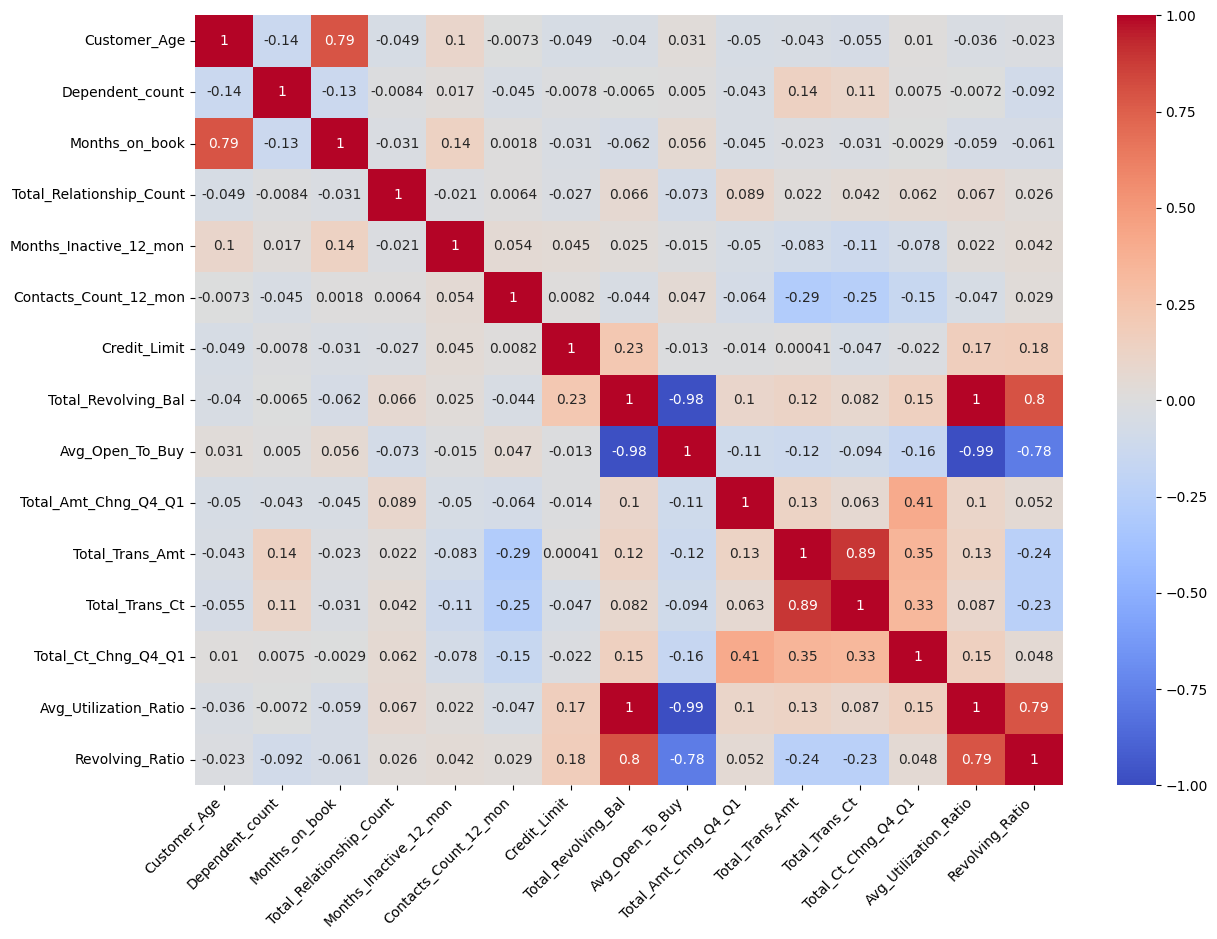

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

high_risk_df = df_risk_classification[df_risk_classification['Risk_Category'] == '1_High']
numeric_df = high_risk_df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(['CLIENTNUM'], axis=1)

sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.gcf().set_size_inches(14, 10)
plt.xticks(rotation=45, ha='right')

plt.show()


### 저위험 고객군 특징
┗저위험군의 특징을 파악하여 고위험군의 프로모션 방향 참조

In [ ]:
# 'Risk_Category' 열에서 '1_High' 값을 가지는 행만 선택하여 새로운 데이터프레임 생성
low_risk_df = df_risk_classification[df_risk_classification['Risk_Category'] == '3_Low']
#low_risk_df.value_counts('Attrition_Flag')



Total Relationship Count for Existing Customers in Low Risk Category: 3127
Total Relationship Count for Attrited Customers in Low Risk Category: 460


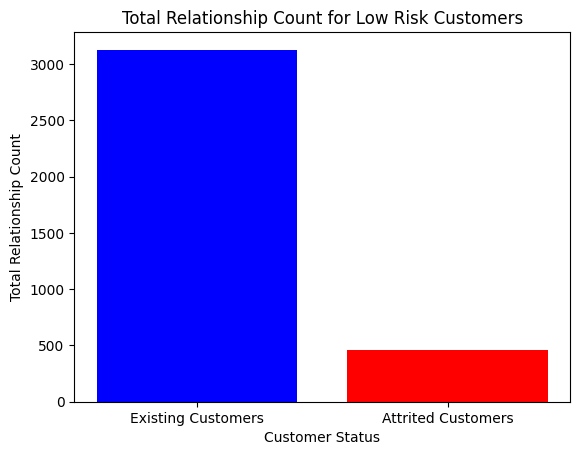

In [ ]:
import matplotlib.pyplot as plt

# 'Risk_Category'가 '3_Low'이고 'Attrition_Flag'가 'Existing Customer'인 행을 필터링
low_risk_existing_customers = low_risk_df[low_risk_df['Attrition_Flag'] == 'Existing Customer']
low_risk_attrited_customers = low_risk_df[low_risk_df['Attrition_Flag'] == 'Attrited Customer']

# 'Total_Relationship_Count' 열 값의 합 계산
existing_total_relationship_count_sum = low_risk_existing_customers['Total_Relationship_Count'].sum()
attrited_total_relationship_count_sum = low_risk_attrited_customers['Total_Relationship_Count'].sum()

print("Total Relationship Count for Existing Customers in Low Risk Category:", existing_total_relationship_count_sum)
print("Total Relationship Count for Attrited Customers in Low Risk Category:", attrited_total_relationship_count_sum)


# 결과값 저장
results = [existing_total_relationship_count_sum, attrited_total_relationship_count_sum]
labels = ['Existing Customers', 'Attrited Customers']

# 막대 그래프 생성
plt.bar(labels, results, color=['blue', 'red'])
plt.xlabel('Customer Status')
plt.ylabel('Total Relationship Count')
plt.title('Total Relationship Count for Low Risk Customers')
plt.show()


Total_Revolving_Bal for Existing Customers in Low Risk Category: 1097871
Total_Revolving_Bal for Attrited Customers in Low Risk Category: 97750


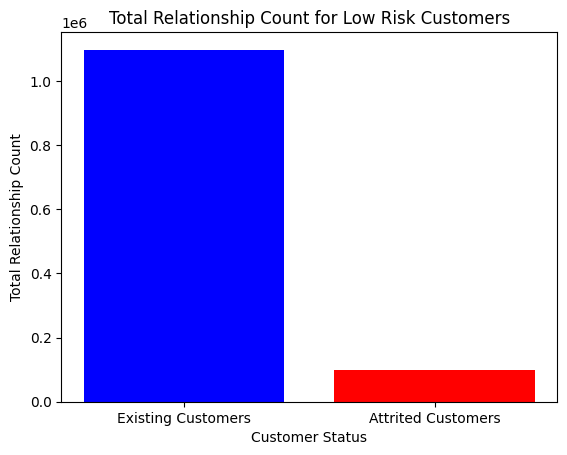

In [ ]:
# 'Total_Re' 열 값의 합 계산
existing_Total_Revolving_Bal_sum = low_risk_existing_customers['Total_Revolving_Bal'].sum()
attrited_Total_Revolving_Balt_sum = low_risk_attrited_customers['Total_Revolving_Bal'].sum()

print("Total_Revolving_Bal for Existing Customers in Low Risk Category:", existing_Total_Revolving_Bal_sum)
print("Total_Revolving_Bal for Attrited Customers in Low Risk Category:", attrited_Total_Revolving_Balt_sum)


# 결과값 저장
results = [existing_Total_Revolving_Bal_sum, attrited_Total_Revolving_Balt_sum]
labels = ['Existing Customers', 'Attrited Customers']

# 막대 그래프 생성
plt.bar(labels, results, color=['blue', 'red'])
plt.xlabel('Customer Status')
plt.ylabel('Total Relationship Count')
plt.title('Total Relationship Count for Low Risk Customers')
plt.show()

▶저위험군 고객중 이탈하지 않은 고객들은 상품가입개수가 많고, 리볼빙을 상대적으로 많이 사용중이다.

---

# Numeric 변수
---

Customer_Age 구간화를 통한 이탈율 확인

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


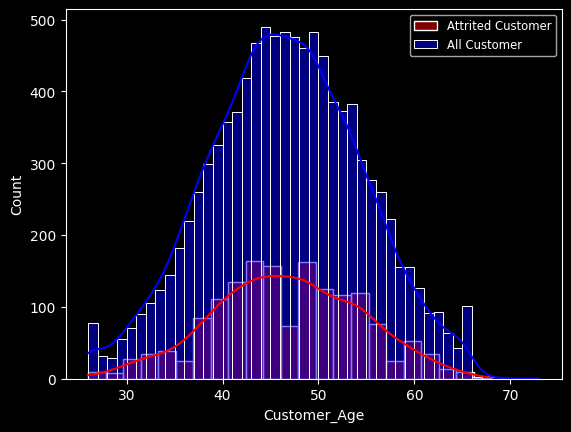

In [ ]:
# ▶ Customer_Age(고객 나이)에 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# 어두운 배경 스타일 적용
plt.style.use(['dark_background'])

# 이탈고객의 나이 분포
sns.histplot(df_risk_classification[df_risk_classification['Attrition_Flag'] == 'Attrited Customer']['Customer_Age'], color='red', kde=True, label='Attrited Customer')

# 전체 고객의 나이 분포
sns.histplot(df_risk_classification['Customer_Age'], color='blue', kde=True, label='All Customer')

# 범례 표시
plt.legend(loc='upper right', fontsize='small')

# 그래프 보이기
plt.show()


In [ ]:
# np.where() : 조건에 따라 값을 반환하는 함수
import numpy as np

df_risk_classification['Customer_Age_gp'] = np.where(
    df_risk_classification['Customer_Age'] <= 40, 1,
    np.where(df_risk_classification['Customer_Age'] <= 60, 2, 3)
)

df_risk_classification[['Customer_Age', 'Customer_Age_gp']]


/tmp/ipykernel_18/4242768489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_classification['Customer_Age_gp'] = np.where(


,Customer_Age,Customer_Age_gp
0,45,2
1,49,2
2,51,2
3,40,1
4,40,1
...,...,...
10122,50,2
10123,41,2
10124,44,2
10125,30,1


In [ ]:
# ▶ 구간화에 따른 고객 이탈율
num_val='Customer_Age_gp'

# ▶ 1단계
df_tran = pd.DataFrame(df_risk_classification.groupby([num_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = num_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,Customer_Age_gp,Attrited Customer,Existing Customer,ratio
0,1,338.0,2033.0,14.3
1,2,1205.0,6012.0,16.7
2,3,58.0,345.0,14.4


Total_Revolving_Bal 구간화를 통한 이탈율 확인

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


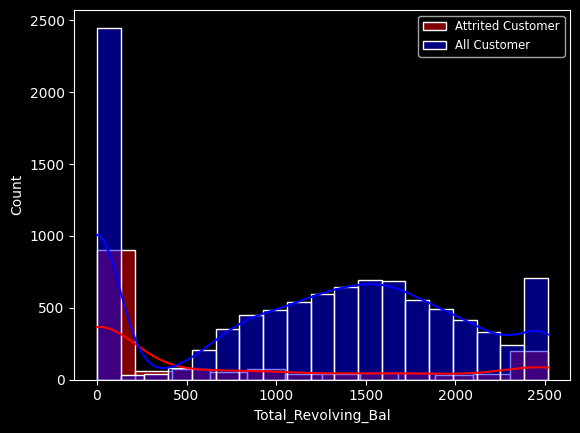

In [ ]:
# ▶ Total_Revolving_Bal(리볼빙 금액)에 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

# 이탈고객의 리볼빙금 분포
sns.histplot(df_risk_classification[df_risk_classification['Attrition_Flag'] == 'Attrited Customer']['Total_Revolving_Bal'], color='red', kde=True, label='Attrited Customer')

#sns.distplot(df_risk_classification['Total_Revolving_Bal']);
sns.histplot(df_risk_classification['Total_Revolving_Bal'], color='blue', kde=True, label='All Customer')
# 범례 표시
plt.legend(loc='upper right', fontsize='small')
# 그래프 보이기
plt.show()

In [ ]:
import numpy as np

df_risk_classification['Total_Revolving_Bal_gp'] = np.where(df_risk_classification['Total_Revolving_Bal'] <= 1000, 1,
                                                    np.where(df_risk_classification['Total_Revolving_Bal'] <= 2000, 2, 3)
)

df_risk_classification[['Total_Revolving_Bal', 'Total_Revolving_Bal_gp']]


/tmp/ipykernel_18/3306537501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_risk_classification['Total_Revolving_Bal_gp'] = np.where(df_risk_classification['Total_Revolving_Bal'] <= 1000, 1,


,Total_Revolving_Bal,Total_Revolving_Bal_gp
0,777,1
1,864,1
2,0,1
3,2517,3
4,0,1
...,...,...
10122,1851,2
10123,2186,3
10124,0,1
10125,0,1


In [ ]:
# ▶ 구간화에 따른 고객 이탈율
num_val='Total_Revolving_Bal_gp'

# ▶ 1단계
df_tran = pd.DataFrame(df_risk_classification.groupby([num_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = num_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot

,Total_Revolving_Bal_gp,Attrited Customer,Existing Customer,ratio
0,1,1146.0,2727.0,29.6
1,2,206.0,4273.0,4.6
2,3,249.0,1390.0,15.2


# Categorical 변수
---

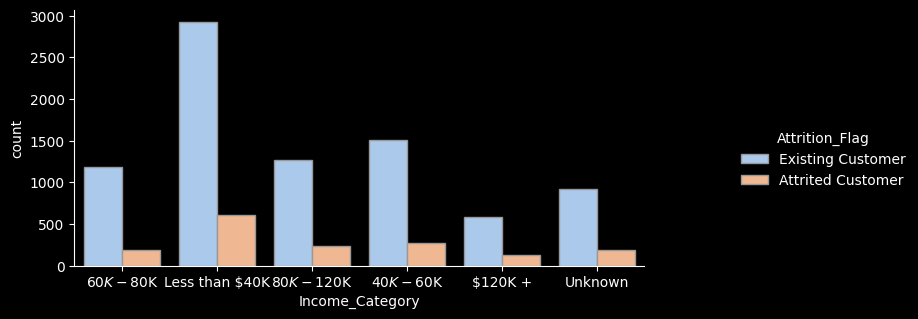

In [ ]:
# ▶ 소득범위에 따른 고객이탈율 비교
sns.catplot(x="Income_Category", hue="Attrition_Flag", kind="count",palette="pastel", edgecolor=".6",data=df_risk_classification);
plt.gcf().set_size_inches(10, 3)

In [ ]:
cat_val='Income_Category'

# ▶ 1단계
df_tran = pd.DataFrame(df_risk_classification.groupby([cat_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = cat_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot.sort_values(by=['ratio'], ascending = False)

,Income_Category,Attrited Customer,Existing Customer,ratio
0,$120K +,124.0,581.0,17.6
4,Less than $40K,606.0,2927.0,17.2
5,Unknown,183.0,915.0,16.7
3,$80K - $120K,237.0,1275.0,15.7
1,$40K - $60K,268.0,1506.0,15.1
2,$60K - $80K,183.0,1186.0,13.4


▶  Education_Level 따른 고객이탈율 비교

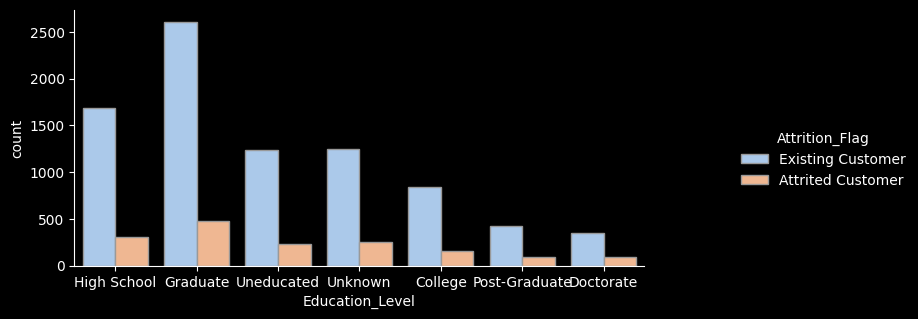

In [ ]:
# ▶ Education_Level 따른 고객이탈율 비교
sns.catplot(x="Education_Level", hue="Attrition_Flag", kind="count",palette="pastel", edgecolor=".6",data=df_risk_classification);
plt.gcf().set_size_inches(10, 3)

In [ ]:
cat_val='Education_Level'

# ▶ 1단계
df_tran = pd.DataFrame(df_risk_classification.groupby([cat_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = cat_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot.sort_values(by=['ratio'], ascending = False)

,Education_Level,Attrited Customer,Existing Customer,ratio
1,Doctorate,93.0,351.0,20.9
4,Post-Graduate,90.0,418.0,17.7
6,Unknown,252.0,1246.0,16.8
5,Uneducated,233.0,1240.0,15.8
2,Graduate,478.0,2606.0,15.5
0,College,153.0,845.0,15.3
3,High School,302.0,1684.0,15.2


---
ML모델링
---------------------------------
▶High 리스크 데이터프레임으로 모델링

▶ML사용한 이유 :

가. 어떤 변수가 이탈율에 영향을 미치는지 확인

나.고위험군에서 이탈한 고객과 이탈하지 않은고객들의 어떤 특징과 차이점이 있는지 확인

▶랜덤포레스트 모델 사용 이유 : 이탈에 영향을 주는 변수의 중요도를 파악하고 싶어 의사결정나무를 실행하려고 했지만 ,의사결정나무는 과적합 위험이 크기때문에 랜덤포레스트 분류모델을 선택하였다. 랜덤포레스트 회귀는 매출같은 선형데이터를 예측할때 사용하는것이고, 분류모델은 우리처럼 범주형 값을 예측할때사용하기 때문에 분류모델을 선택하여 feature importance 파악후 세부분석 진행하기 위해 선택

#  모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
high_risk_df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Revolving_Ratio,Risk_Category
21,708508758,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,...,1438.3,0,1438.3,1.047,692,16,0.600,0.000,0.0,1_High
51,779471883,Attrited Customer,54,F,1,Graduate,Married,Less than $40K,Blue,40,...,1438.3,808,630.3,0.997,705,19,0.900,0.562,114.6,1_High
68,711314058,Existing Customer,49,M,2,Graduate,Married,$60K - $80K,Blue,32,...,1687.0,1107,580.0,1.715,1670,17,2.400,0.656,66.3,1_High
95,719712633,Existing Customer,64,M,1,Graduate,Married,Less than $40K,Blue,52,...,1709.0,895,814.0,1.656,1673,32,0.882,0.524,53.5,1_High
108,808284783,Existing Customer,62,F,1,Unknown,Married,Less than $40K,Blue,56,...,1438.3,0,1438.3,0.813,1951,44,1.095,0.000,0.0,1_High


In [ ]:
# 'Attrition_Flag' 컬럼 값 변환
# 딕셔너리를 사용하여 치환할 값들을 정의
pd.set_option('future.no_silent_downcasting', True)

replace_dict = {'Existing Customer': 0, 'Attrited Customer': 1}

# 'Attrition_Flag' 열의 값을 치환
high_risk_df.loc[:, 'Attrition_Flag'] = high_risk_df['Attrition_Flag'].replace(replace_dict)
high_risk_df.value_counts('Attrition_Flag')

Attrition_Flag
0    713
1    287
Name: count, dtype: int64

In [ ]:
categorical_list

['Attrition_Flag',
 'Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [ ]:
# ▶ 사용하지 않을 Categorical 변수는 리스트에서 제외
#categorical_list.remove('Gender')
categorical_list.remove('Card_Category')
categorical_list.remove('Attrition_Flag')
categorical_list

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

모든 변수를 사용하여 모델링 결과 : 총거래금액(횟수), 1분기대비 4분기 변동비율이 중요한 지표로 표현

▶ 예측가능한 변수가 중요순위 상위권차지 (정확도를 높이는데 사용된것으로 추정)

▶ 고객의 거래량이 적을 수록 이탈확률이 높다

▶ 상위 변수 제거후 모델링 추가진행

 ---


![1.png](attachment:cb1aa254-8748-4676-af69-d0952704abcf.png)

In [ ]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report

# 'Total_Trans_Amt','Total_Ct_Chng_Q4_Q1','Total_Amt_Chng_Q4_Q1'
X=high_risk_df.drop(['CLIENTNUM', 'Attrition_Flag','Card_Category','Total_Trans_Ct','Months_on_book','Total_Trans_Amt','Total_Ct_Chng_Q4_Q1','Total_Amt_Chng_Q4_Q1','Revolving_Ratio','Avg_Utilization_Ratio','Risk_Category','Avg_Open_To_Buy'], axis=1)
#X=high_risk_df.drop(['CLIENTNUM', 'Attrition_Flag','Card_Category','Total_Trans_Ct','Months_on_book','Total_Trans_Amt','Total_Ct_Chng_Q4_Q1','Total_Amt_Chng_Q4_Q1','Revolving_Ratio','Avg_Utilization_Ratio','Risk_Category'], axis=1)
Y=high_risk_df['Attrition_Flag']

# train_test_split() : 데이터를 학습용(train)과 테스트용(test)으로 나눈다
# test_size 매개변수 : 테스트 세트의 비율을 설정
# stratify 매개변수: 클래스 레이블의 분포를 유지하도록 설정
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(700, 11)
(700,)
(300, 11)
(300,)


*Label Encoding:
1. 각 범주에 대해 정수 값을 할당하여 변수를 변환합니다.
2. 범주형 변수의 순서를 고려할 수 있습니다.
3. 트리 기반 알고리즘에는 영향을 미치지 않지만,
4. 선형 모델과 같은 알고리즘에서는 범주의 순서를 잘못 인식할 수 있습니다.

*One-hot Encoding:
1. 각 범주를 이진 변수로 변환하여 사용합니다.
2. 범주의 순서를 고려하지 않습니다.
3. 범주형 변수의 차원이 늘어나게 되어 차원의 저주 문제가 발생할 수 있습니다.
4. 특히 범주가 많은 경우에는 더 심각한 문제가 될 수 있습니다.

In [ ]:
# ▶ Categorical(범주형) 변수는 One-hot-encoding or Label-encoding을 통해 숫자형 변수로 변경해야함
# ▶ One-hot-encoding은 차원이 많은 변수에는 불리, Label-encoding은 회귀관련 알고리즘에서는 사용 어려움.(※Tree 계열 알고리즘에서는 사용 가능)

from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])


Gender
Education_Level
Marital_Status
Income_Category


In [ ]:
x_train[categorical_list].head()

,Gender,Education_Level,Marital_Status,Income_Category
1043,0,2,1,4
5982,0,2,1,4
8189,0,3,2,4
6356,0,4,1,4
3505,1,3,2,1


In [ ]:
x_test[categorical_list].head()

,Gender,Education_Level,Marital_Status,Income_Category
4208,1,1,2,1
4870,0,0,2,4
6470,0,3,1,4
5257,0,3,3,4
7122,0,4,1,4


# 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
# 학습 단계
# n_estimators : 생성할 트리의 개수 지정
# max_depth : 트리의 최대 깊이(=노드)를 제어
# random_state : 모델에서 사용되는 무작위성을 제어,  랜덤 시드를 설정하여 결과를 재현가능하게 만든다.

#학습은 훈련 데이터만 학습
# 데이터타입 변경
y_train = y_train.astype(int)

rfc = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=1239)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=500, random_state=1239)

In [ ]:
# ▶ 예측
# ▶ 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score



# 데이터셋에 대한 예측값을 생성
# 예측은 훈련과 테스트 데이터 모두 예측
# predict() 함수는 각 클래스에 속할 확률을 반환(임계값 조절 가능)
# predict() 함수는 클래스 레이블을 반환하는 것이 아니라, 각 클래스에 속할 확률을 반환
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

y_test = y_test.astype(int)

# classification_report() : 데이터셋에 대한 분류 모델의 성능을 평가
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87       499
           1       0.98      0.23      0.38       201

    accuracy                           0.78       700
   macro avg       0.87      0.62      0.62       700
weighted avg       0.83      0.78      0.73       700

              precision    recall  f1-score   support

           0       0.74      0.98      0.85       214
           1       0.78      0.16      0.27        86

    accuracy                           0.75       300
   macro avg       0.76      0.57      0.56       300
weighted avg       0.75      0.75      0.68       300



1. 정확도 (Accuracy): 전체 예측 중 올바르게 분류된 비율입니다. 즉, 전체 예측 중에서 실제값과 예측값이 일치하는 비율을 나타냅니다.
2. 정밀도 (Precision): 모델이 양성으로 예측한 데이터 중에서 실제로 양성인 데이터의 비율을 나타냅니다. 즉, 양성으로 예측한 것 중에서 실제로 양성인 비율입니다.
3. 재현율 (Recall): 실제 양성인 데이터 중에서 모델이 양성으로 올바르게 예측한 데이터의 비율을 나타냅니다. 즉, 실제로 양성인 것 중에서 양성으로 예측한 비율입니다.
4. F1 점수 (F1-score): 정밀도와 재현율의 조화평균입니다. 모델의 정밀도와 재현율이 어떤 조화를 이루고 있는지를 나타냅니다.
---


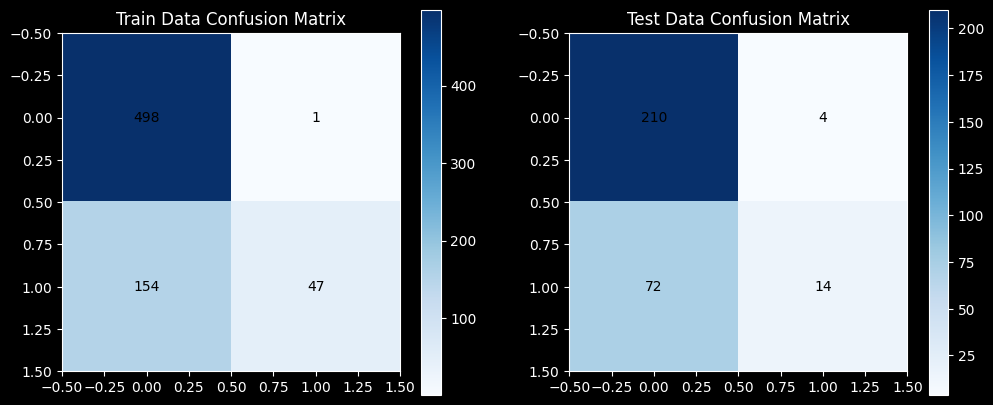

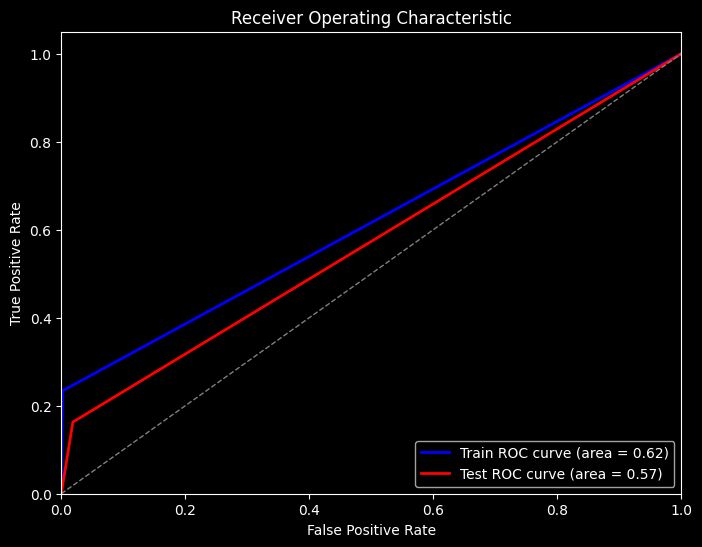

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# 훈련 데이터의 오차 행렬 생성
cm_train = confusion_matrix(y_train, y_pred_train)

# 테스트 데이터의 오차 행렬 생성
cm_test = confusion_matrix(y_test, y_pred_test)

# 오차 행렬 시각화 (가로로 배열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 훈련 데이터 오차 행렬
im1 = ax1.imshow(cm_train, cmap='Blues', interpolation='nearest')
ax1.set_title('Train Data Confusion Matrix')
plt.colorbar(im1, ax=ax1)

# 각 셀에 값 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        text = ax1.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

# 테스트 데이터 오차 행렬
im2 = ax2.imshow(cm_test, cmap='Blues', interpolation='nearest')
ax2.set_title('Test Data Confusion Matrix')
plt.colorbar(im2, ax=ax2)

# 각 셀에 값 표시
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        text = ax2.text(j, i, cm_test[i, j], ha="center", va="center", color="black")

plt.show()


# ROC 곡선 및 AUC 계산
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



# Hyper parameter 튜닝
---
※Grid Search

▶ 가능한 모든 조합을 탐색하는 것도 방법. 그러나 계산 비용이 많이 들 수 있다

▶ 랜덤 서치(Random Search)를 사용하여 트리 개수를 무작위로 선택하는 법을 사용하거나 간격등을 조절해 사용

100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


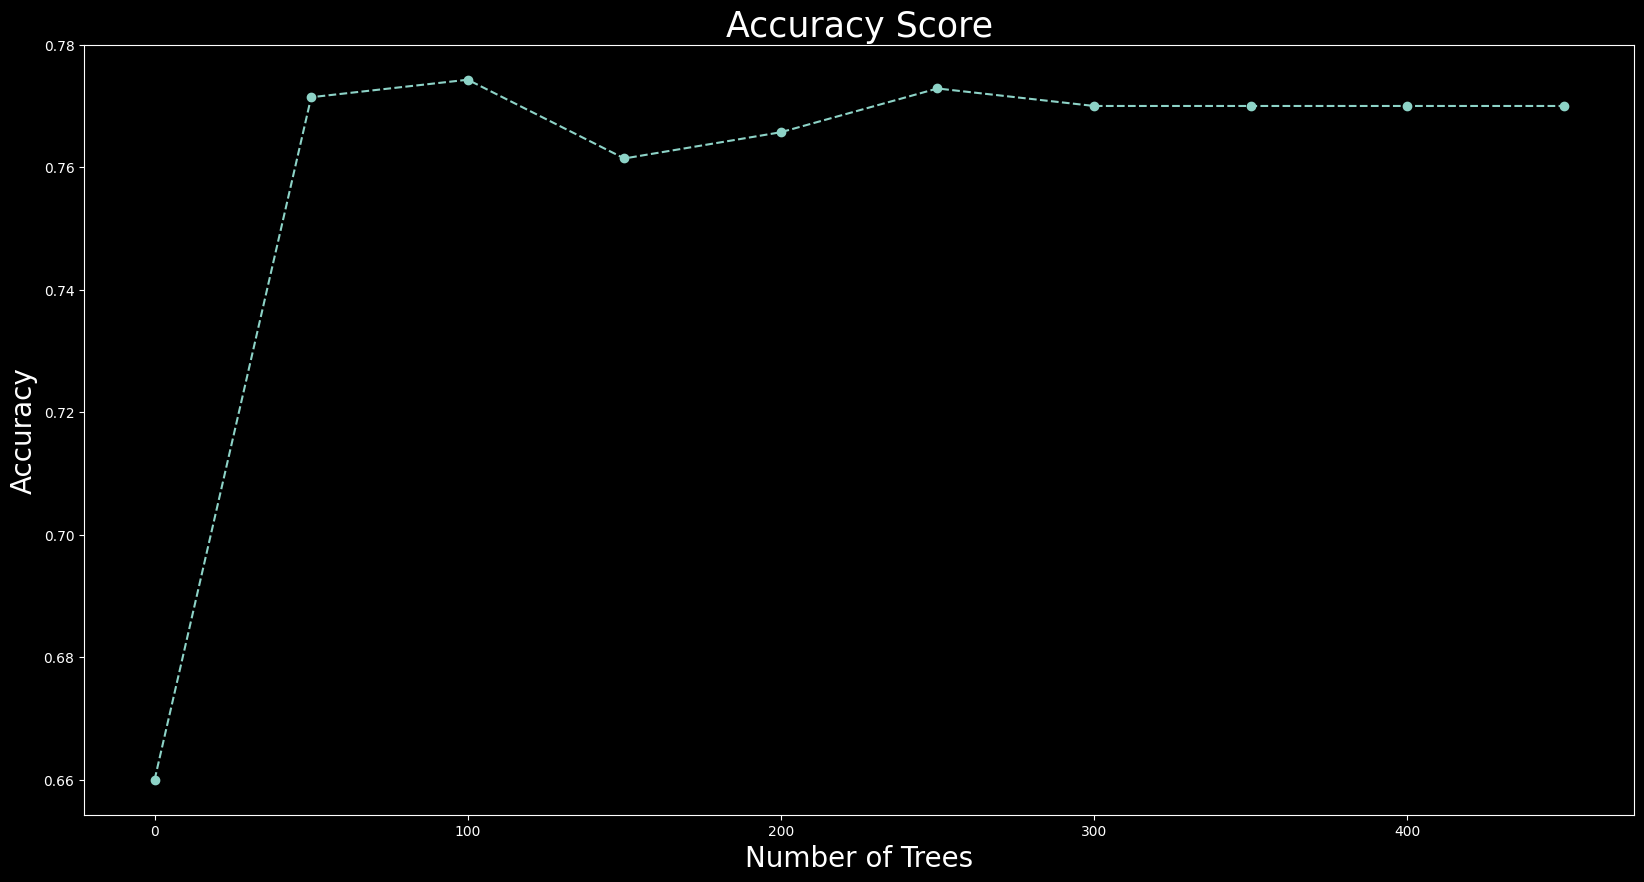

최적의 트리 개수: 100


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


cv_scores = []
estimator_list = [i for i in range(0, 500, 50)] # 테스트를 50단계씩

for i in tqdm(range(0, 500, 50)):
    rfc = RandomForestClassifier(
        n_estimators=i + 1,
        n_jobs=-1,
        random_state=1239
    )
    score = cross_val_score(rfc, x_train, y_train, cv=10, scoring='accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]

plt.figure(figsize=(20, 10))
plt.plot(estimator_list, cv_scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Trees', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy Score', fontsize=25)
plt.show()

print("최적의 트리 개수:", best_e[0])



100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


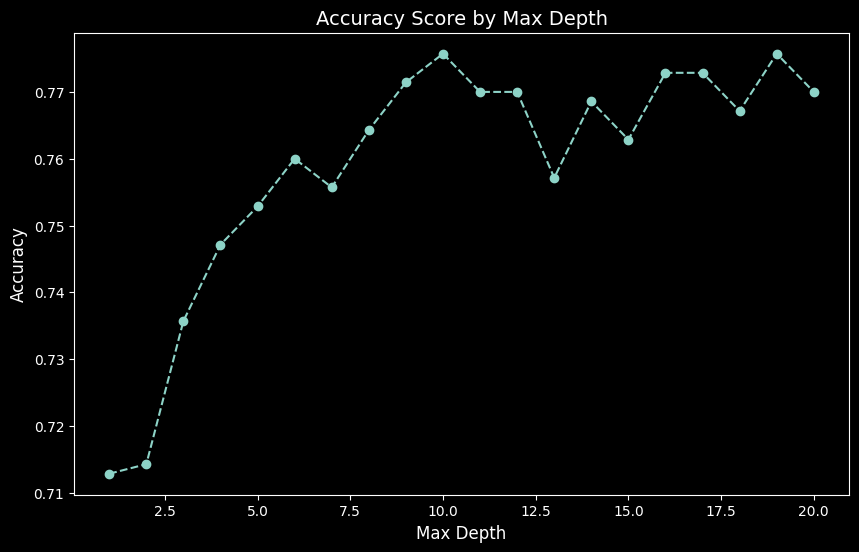

Best Max Depth: 10


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cv_scores = []
max_depth_list = [i for i in range(1, 21)]  # 변수개수로 사용

for depth in tqdm(max_depth_list):
    rfc = RandomForestClassifier(
        n_estimators=100,  # 모델링에서 사용한 트리 수치
        max_depth=depth,
        n_jobs=-1,
        random_state=1239
    )
    score = cross_val_score(rfc, x_train, y_train, cv=10, scoring='accuracy').mean()
    cv_scores.append(score)

best_depth = max_depth_list[np.argmax(cv_scores)]

plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, cv_scores, marker='o', linestyle='dashed')
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Score by Max Depth', fontsize=14)
plt.show()

print("Best Max Depth:", best_depth)


오버샘플링

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler 객체 생성
# 소수 클래스(1클래스)의 데이터만 오버샘플링
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)


# 오버샘플링을 적용하여 새로운 학습 데이터 생성
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

# 새로운 학습 데이터의 크기 출력
print("샘플링 이후 학습 데이터 크기:", x_train_resampled.shape)

# 모델 재학습
#rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1239)
rfc = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=1239, min_samples_split=10,min_samples_leaf=5)
rfc.fit(x_train_resampled, y_train_resampled)


샘플링 이후 학습 데이터 크기: (998, 11)


RandomForestClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=10,
                       random_state=1239)

In [ ]:
#오버샘플링으로 데이터 수 증가 확인
y_train_resampled.value_counts()

Attrition_Flag
1    499
0    499
Name: count, dtype: int64

In [ ]:
# ▶ 예측
# ▶ 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가함(※ 과적합 여부 판별)
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# 데이터셋에 대한 예측값을 생성
# 예측은 훈련과 테스트 데이터 모두 예측
# predict() 함수는 각 클래스에 속할 확률을 반환(임계값 조절 가능)
# predict() 함수는 클래스 레이블을 반환하는 것이 아니라, 각 클래스에 속할 확률을 반환
y_pred_train = rfc.predict(x_train_resampled)
y_pred_test = rfc.predict(x_test)

# classification_report() : 데이터셋에 대한 분류 모델의 성능을 평가
print(classification_report(y_train_resampled, y_pred_train))
print(classification_report(y_test, y_pred_test))


#오버샘플링: 불균형한 클래스를 처리하기 위해 오버샘플링이나 언더샘플링을 적용한 경우, 모델이 데이터에 과적합되어 Precision이 낮아질 수 있다

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       499
           1       0.78      0.84      0.81       499

    accuracy                           0.80       998
   macro avg       0.80      0.80      0.80       998
weighted avg       0.80      0.80      0.80       998

              precision    recall  f1-score   support

           0       0.85      0.71      0.78       214
           1       0.49      0.70      0.58        86

    accuracy                           0.71       300
   macro avg       0.67      0.70      0.68       300
weighted avg       0.75      0.71      0.72       300



오차행렬:모델의 분류 결과를 직접적으로 표시하고 분류 오류를 분석, 모델의 분류 성능을 평가하고 시각화

  -왼쪽위: 0을 정확히 예측한 경우의 합계
  
  -오른쪽위: 0을 1로 잘못 예측한 경우의 합계
  
  -왼쪽아래: 1을 0으로 잘못 예측한 경우의 합계
  
  -오른쪽아래: 1을 정확히 예측한 경우의 합계

ROC 그래프: 임계값에 따른 모델의 분류 성능을 시각화, 모델의 전반적인 성능 및 특성을 파악




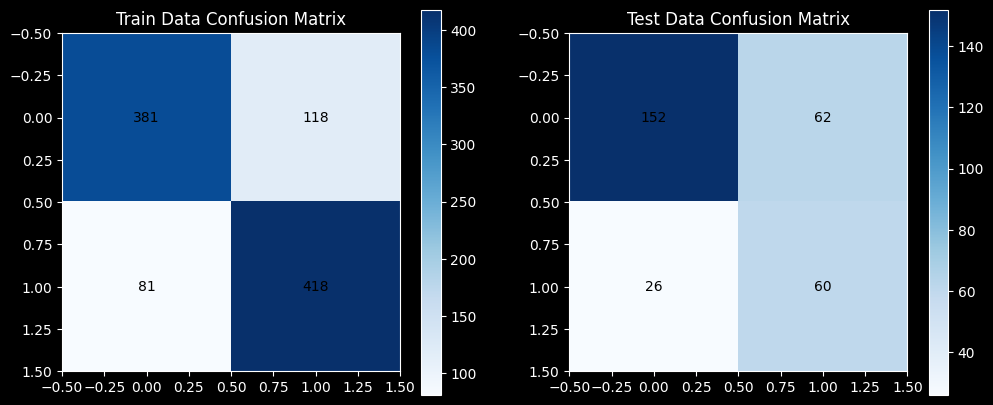

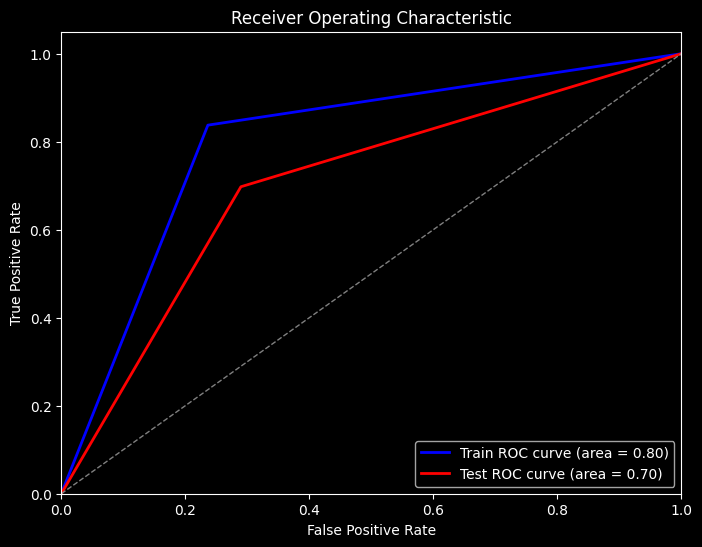

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# 훈련 데이터의 오차 행렬 생성
cm_train = confusion_matrix(y_train_resampled, y_pred_train)

# 테스트 데이터의 오차 행렬 생성
cm_test = confusion_matrix(y_test, y_pred_test)

# 오차 행렬 시각화 (가로로 배열)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 훈련 데이터 오차 행렬
im1 = ax1.imshow(cm_train, cmap='Blues', interpolation='nearest')
ax1.set_title('Train Data Confusion Matrix')
plt.colorbar(im1, ax=ax1)

# 각 셀에 값 표시
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        text = ax1.text(j, i, cm_train[i, j], ha="center", va="center", color="black")

# 테스트 데이터 오차 행렬
im2 = ax2.imshow(cm_test, cmap='Blues', interpolation='nearest')
ax2.set_title('Test Data Confusion Matrix')
plt.colorbar(im2, ax=ax2)

# 각 셀에 값 표시
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        text = ax2.text(j, i, cm_test[i, j], ha="center", va="center", color="black")

plt.show()


# ROC 곡선 및 AUC 계산
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)


# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



# 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

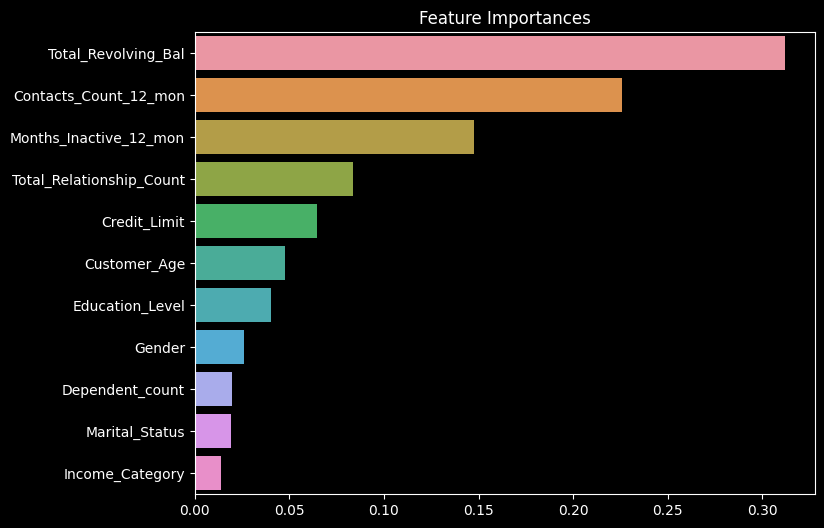

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train_resampled.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# SHAP Value

In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


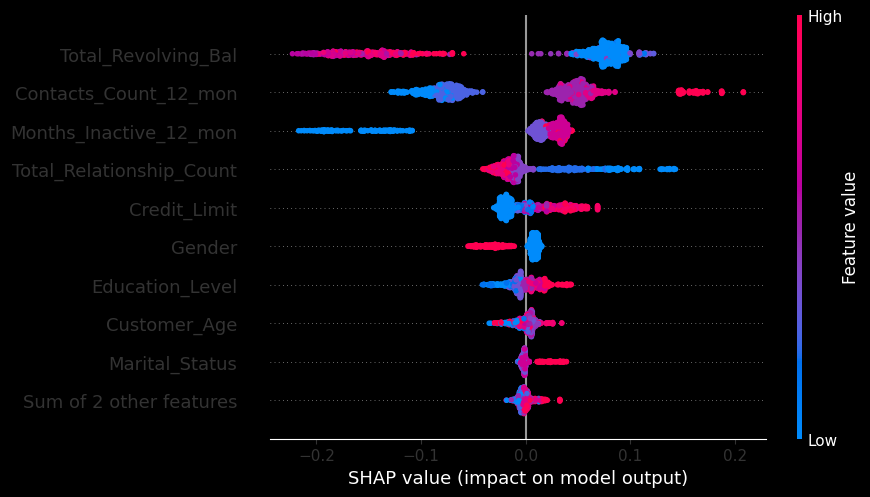

In [ ]:
# SHAP 라이브러리 임포트
import shap

# RandomForestClassifier 모델을 생성하고 학습
explainer = shap.TreeExplainer(rfc)
shap_values = explainer(x_train_resampled)

# 1이 이탈한 고객임으로 shap_values 1을 선택
shap.plots.beeswarm(shap_values[:,:,1])



In [ ]:
import numpy as np

feature_names = x_train_resampled.columns.tolist()

# 변수 중요도
for i, feature_name in enumerate(feature_names):
    feature_imp = np.mean(np.abs(shap_values[:, i].values))
    print(f'{feature_names[i]}의 중요도:', feature_imp)


Customer_Age의 중요도: 0.006281719647239703
Gender의 중요도: 0.013379567554139132
Dependent_count의 중요도: 0.0031239315102857485
Education_Level의 중요도: 0.01066558132465322
Marital_Status의 중요도: 0.0036386940107599615
Income_Category의 중요도: 0.0023597692431791472
Total_Relationship_Count의 중요도: 0.025355886500734587
Months_Inactive_12_mon의 중요도: 0.04147340406336974
Contacts_Count_12_mon의 중요도: 0.06859584324650335
Credit_Limit의 중요도: 0.020068511628998652
Total_Revolving_Bal의 중요도: 0.10297575500380654


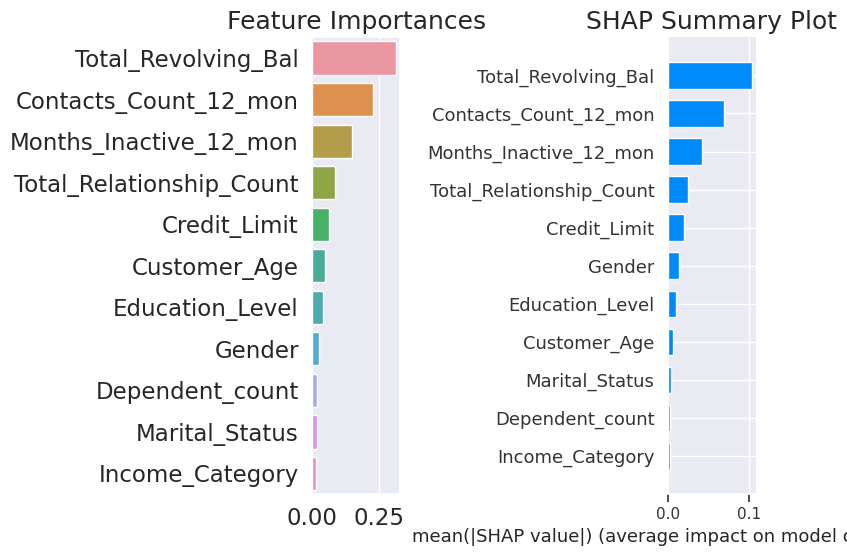

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd

# 시각화 스타일 설정
plt.style.use(['dark_background'])
plt.rcParams['font.size'] = 30
sns.set(style="darkgrid", font_scale=1.5)  # 배경색을 밝은 색상으로 변경, 폰트 크기 조정

# 특성 중요도 시각화
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train_resampled.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

# SHAP 값 계산
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(x_train_resampled)
shap_values_class_1 = shap_values[1]  # 클래스 1에 대한 SHAP 값 선택

# 그래프 크기 설정
fig, axes = plt.subplots(1, 2, figsize=(50, 50))

# 첫 번째 그래프: 특성 중요도
axes[0].set_title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, ax=axes[0])

# 두 번째 그래프: SHAP summary plot
axes[1].set_title('SHAP Summary Plot')

# SHAP summary plot을 별도의 figure로 그린 후 이를 캡처하여 서브플롯에 추가
shap.summary_plot(shap_values_class_1, x_train_resampled, plot_type="bar", max_display=x_train_resampled.shape[1])
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
shap_plot_img = plt.imread('shap_summary_plot.png')
axes[1].imshow(shap_plot_img)
axes[1].axis('off')  # 축 제거

# 두 번째 서브플롯의 위치를 오른쪽으로 이동
pos = axes[1].get_position()
axes[1].set_position([pos.x0 + 0.1, pos.y0, pos.width, pos.height])

plt.tight_layout()
plt.show()


# Rule Extraction
---
의사결정나무

▶Dicision Tree : 데이터를 분할하여 예측을 수행하는 방식으로, 각 분할(노드)은 특정 Feature와 그 임계값에 기반하여 이루어진다. 분할과정을 통해 최종적으로 리프노드에 도달하는데, 각 리프노드는 특정 클래스 또는 예측값을 나타낸다.

▶Rule Extraction : 각 리프노드 까지 도달하는 경로가 곧 분류 규칙이다. 추출하는 과정은 각 노드에서의 분할 조건을 따라가면 리프노드에 도달하는 경로가 하나의 규칙이라고 보면 된다.

ex)

Root Node: Feature1 <= 5

      &emsp;Left Child: Feature2 > 3
      
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Leaf Node: Class A
        
      &emsp;Right Child: Feature3 <= 2
      
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Leaf Node: Class B
    
Rule01. If Feature1 <= 5 and Feature2 > 3, then Class = A

Rule02. If Feature1 > 5 and Feature3 <= 2, then Class = B

In [ ]:
categorical_list

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category']

In [ ]:
# ▶ 사용하지 않을 Categorical 변수는 리스트에서 제외
 #categorical_list.remove('Gender')
categorical_list.remove('Marital_Status')
categorical_list.remove('Income_Category')
categorical_list.remove('Gender')
categorical_list.remove('Education_Level')
#categorical_list.remove('Dependent_count')

# ▶ Risk_Category 변수는 없기 때문에 추가
categorical_list.append('Dependent_count')

In [ ]:
# ▶ 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구분하는 단계
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 의사결정나무 모델 초기화
#dtc = DecisionTreeClassifier( max_depth=4, random_state=1239, min_samples_split=10,min_samples_leaf=5)
# 의사결정나무 모델 초기화 및 학습 (클래스 가중치 적용)
dtc = DecisionTreeClassifier(max_depth=4, random_state=1239, min_samples_split=10, min_samples_leaf=5, class_weight='balanced')
dtc.fit(x_train, y_train)



X = high_risk_df[['Customer_Age', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon','Total_Revolving_Bal','Dependent_count']]
#X = high_risk_df[[ 'Months_Inactive_12_mon', 'Contacts_Count_12_mon','Total_Revolving_Bal']]
Y = high_risk_df['Attrition_Flag']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(700, 5)
(700,)
(300, 5)
(300,)


In [ ]:
# ▶ Categorical(범주형) 변수는 One-hot-encoding or Label-encoding을 통해 숫자형 변수로 변경해야함
# ▶ One-hot-encoding은 차원이 많은 변수에는 불리, Label-encoding은 회귀관련 알고리즘에서는 사용 어려움.(※Tree 계열 알고리즘에서는 사용 가능)

from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
    print(col)
    le = LabelEncoder()
    le.fit(list(x_train[col].values) + list(x_test[col].values))
    x_train[col] = le.transform(x_train[col])
    x_test[col] = le.transform(x_test[col])


#학습은 훈련 데이터만 학습
# 데이터타입 변경
x_train = x_train.astype(int)
y_train = y_train.astype(int)

x_train[categorical_list].head()

Dependent_count


,Dependent_count
6968,1
8361,5
6491,0
8023,4
8202,1


In [ ]:
#학습은 훈련 데이터만 학습
# 데이터타입 변경
x_train = x_train.astype(int)
y_train = y_train.astype(int)

x_test = x_test.astype(int)
y_test = y_test.astype(int)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 6968 to 2788
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Customer_Age            700 non-null    int64
 1   Months_Inactive_12_mon  700 non-null    int64
 2   Contacts_Count_12_mon   700 non-null    int64
 3   Total_Revolving_Bal     700 non-null    int64
 4   Dependent_count         700 non-null    int64
dtypes: int64(5)
memory usage: 32.8 KB


In [ ]:
# 모델 훈련
dtc.fit(x_train, y_train)

# 테스트 세트를 사용하여 예측
y_pred = dtc.predict(x_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,2))
print(classification_report(y_test, y_pred))


Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.88      0.65      0.74       217
           1       0.45      0.76      0.57        83

    accuracy                           0.68       300
   macro avg       0.66      0.70      0.65       300
weighted avg       0.76      0.68      0.69       300



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE


# Feature와 Target 데이터 분리
X = high_risk_df[['Customer_Age', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Dependent_count']]
Y = high_risk_df['Attrition_Flag']

# Train/Test 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1239)

# 레이블 데이터 형식 변환
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# SMOTE 적용
smote = SMOTE(random_state=1239)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# 데이터 크기 확인
print("Original x_train shape:", x_train.shape)
print("Resampled x_train shape:", x_train_resampled.shape)
print("Original y_train distribution:\n", y_train.value_counts())
print("Resampled y_train distribution:\n", y_train_resampled.value_counts())

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 그리드 서치 설정
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train_resampled, y_train_resampled)

# 최적의 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)

# 최적의 모델로 예측
best_dtc = grid_search.best_estimator_
y_pred = best_dtc.predict(x_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 2))
print(classification_report(y_test, y_pred))


Original x_train shape: (700, 5)
Resampled x_train shape: (1012, 5)
Original y_train distribution:
 Attrition_Flag
0    506
1    194
Name: count, dtype: int64
Resampled y_train distribution:
 Attrition_Flag
0    506
1    506
Name: count, dtype: int64
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       207
           1       0.47      0.65      0.54        93

    accuracy                           0.66       300
   macro avg       0.64      0.66      0.64       300
weighted avg       0.70      0.66      0.67       300



▶지니 불순도

지니 불순도는 0부터 0.5까지의 값을 가진다. 0은 완전히 순수한 상태를 나타내며, 0.5는 가장 불순한 상태를 나타낸다. 지니 불순도가 높은경우, 불확실성증가, 분류의 어려움, 과적합 위험, 일반화 성능 저하 등의 문제가 발생할 수 있다.

[Text(0.5446428571428571, 0.9, 'Total_Revolving_Bal <= 553.5\ngini = 0.5\nsamples = 700\nvalue = [350.0, 350.0]\nclass = Existing Customer'),
 Text(0.2857142857142857, 0.7, 'Contacts_Count_12_mon <= 2.5\ngini = 0.473\nsamples = 410\nvalue = [174.294, 279.657]\nclass = Attrited Customer'),
 Text(0.14285714285714285, 0.5, 'Months_Inactive_12_mon <= 1.5\ngini = 0.495\nsamples = 182\nvalue = [95.968, 78.922]\nclass = Existing Customer'),
 Text(0.07142857142857142, 0.3, 'Customer_Age <= 36.5\ngini = 0.201\nsamples = 40\nvalue = [26.815, 3.431]\nclass = Existing Customer'),
 Text(0.03571428571428571, 0.1, 'gini = 0.495\nsamples = 8\nvalue = [4.234, 3.431]\nclass = Existing Customer'),
 Text(0.10714285714285714, 0.1, 'gini = 0.0\nsamples = 32\nvalue = [22.581, 0.0]\nclass = Existing Customer'),
 Text(0.21428571428571427, 0.3, 'Contacts_Count_12_mon <= 1.5\ngini = 0.499\nsamples = 142\nvalue = [69.153, 75.49]\nclass = Attrited Customer'),
 Text(0.17857142857142858, 0.1, 'gini = 0.475\nsamples 

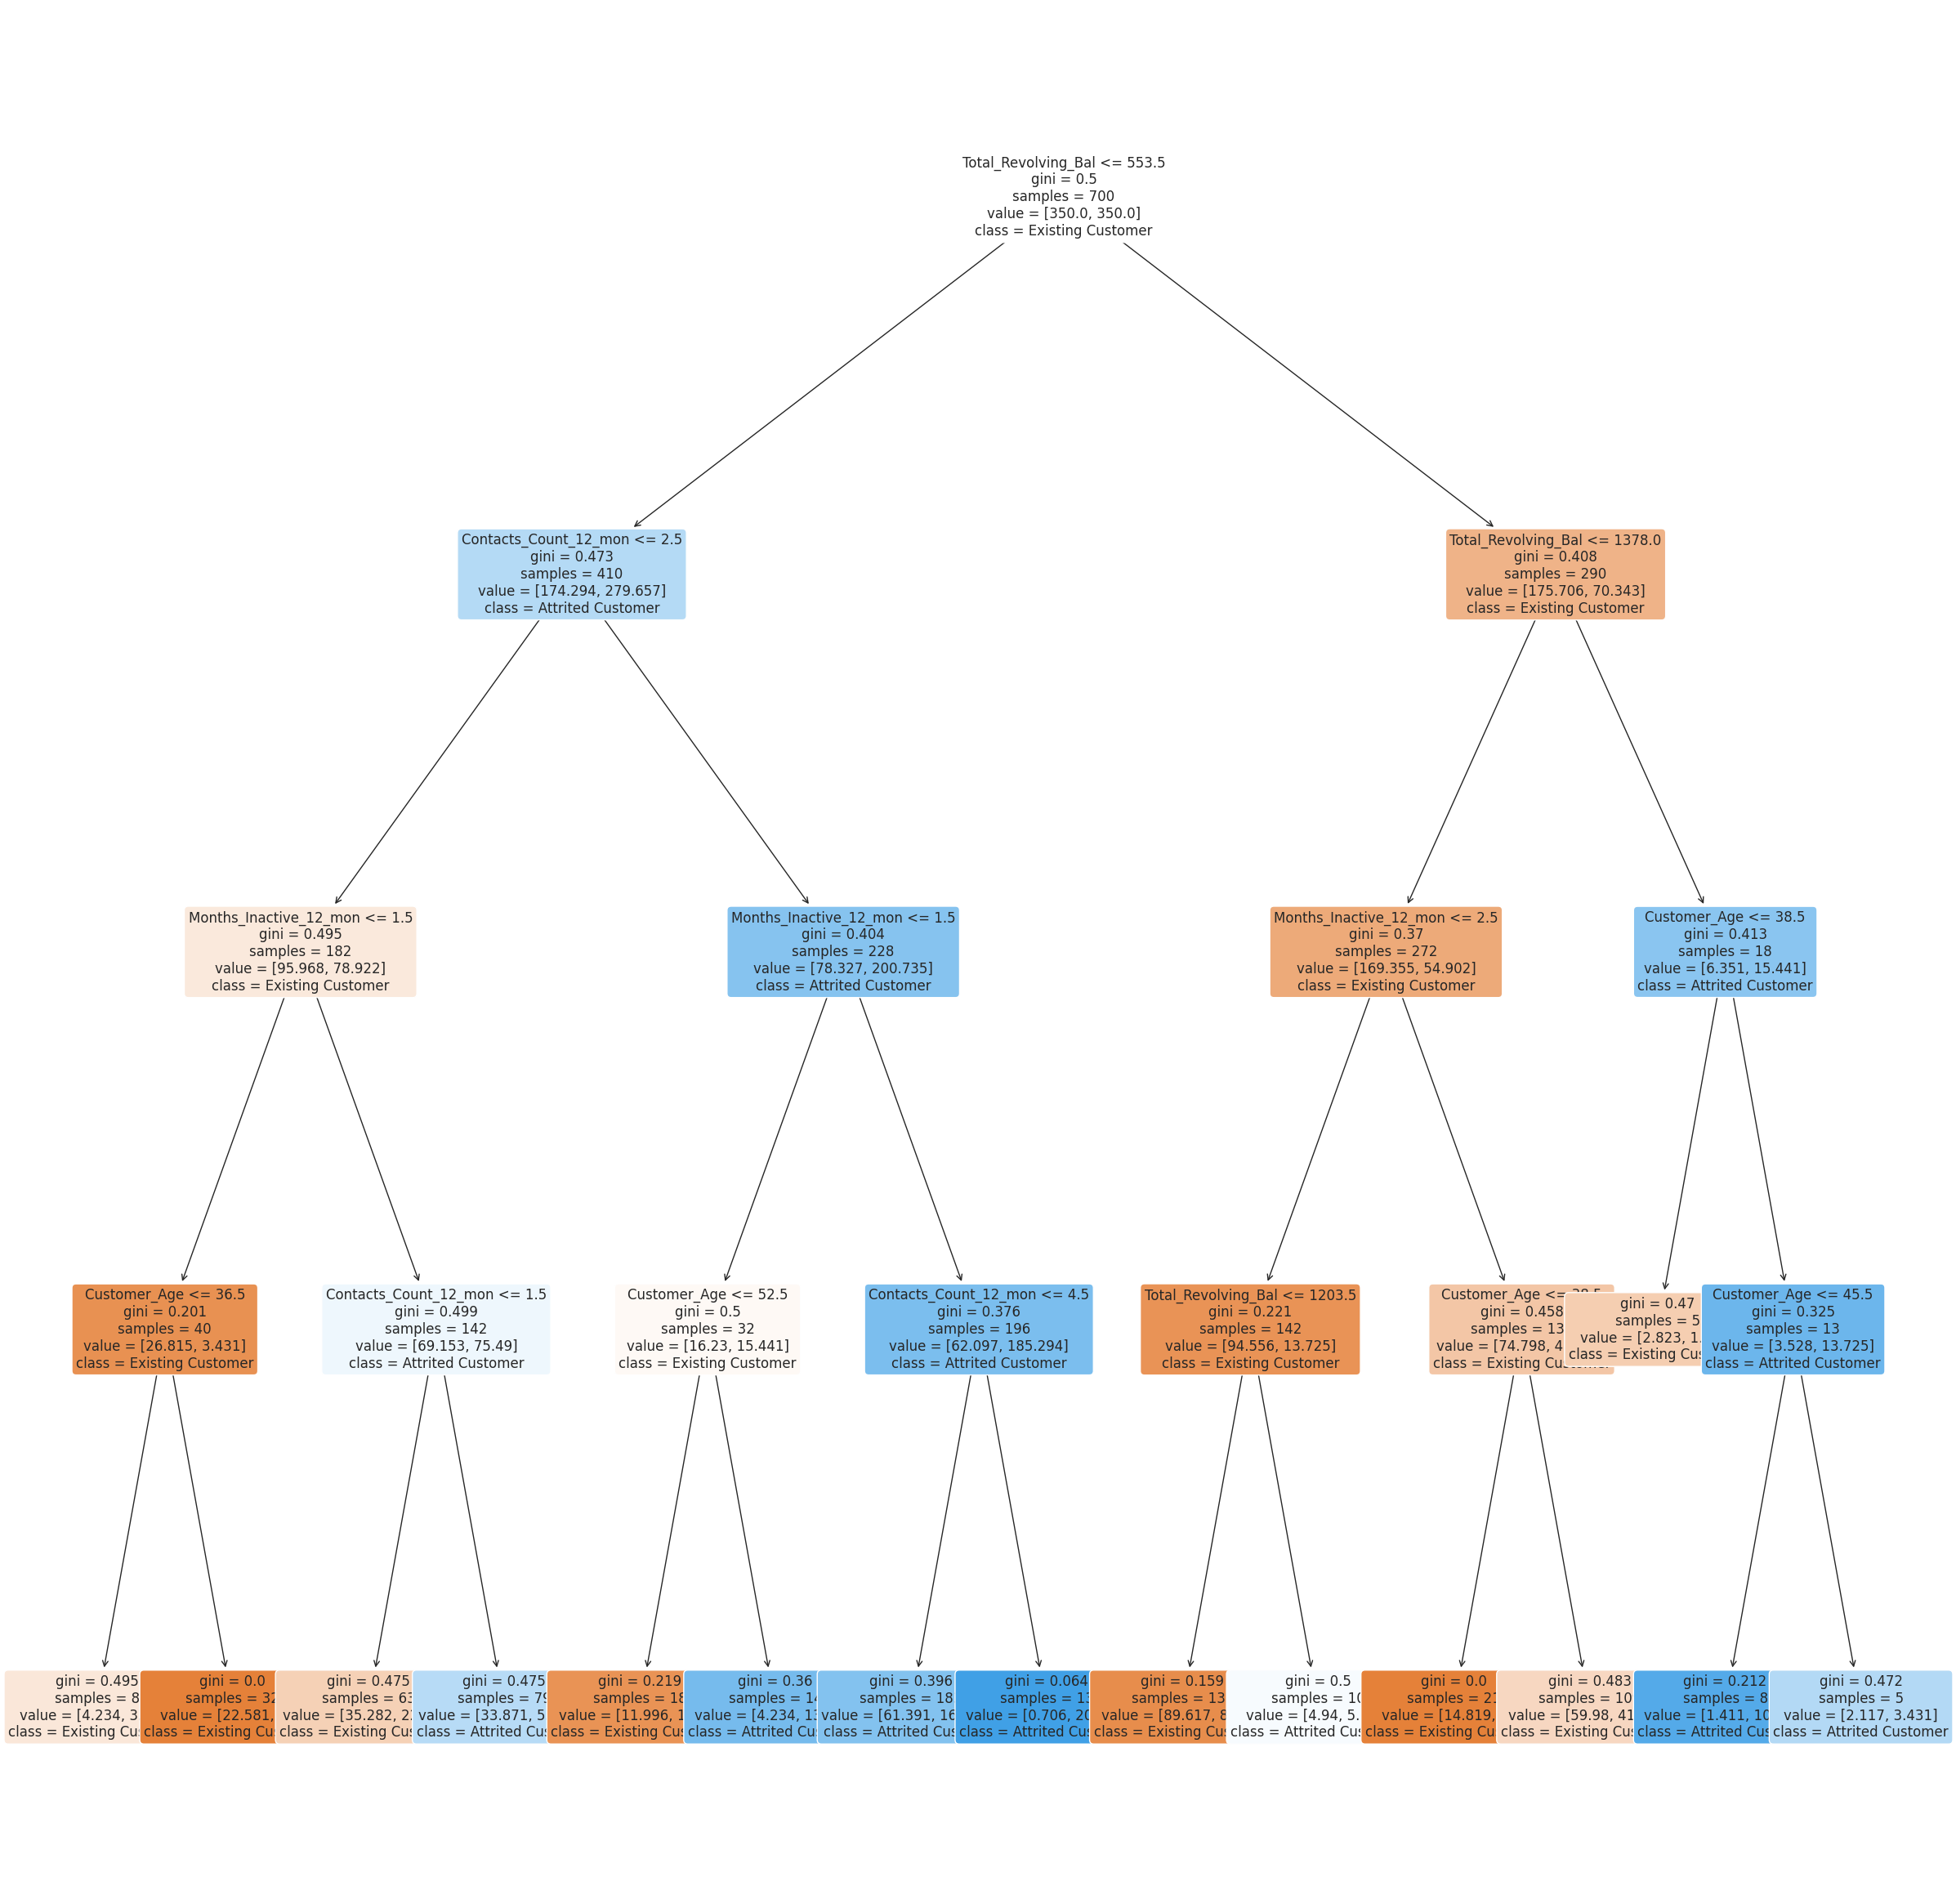

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



# 의사결정나무 시각화
plt.figure(figsize=(30,30))
plot_tree(dtc, feature_names=X.columns, class_names=['Existing Customer', 'Attrited Customer'], filled=True, rounded=True, fontsize=12)


In [ ]:
# 규칙 추출
from sklearn.tree import export_text
tree_rules = export_text(dtc, feature_names=list(X.columns))
print(tree_rules)

|--- Total_Revolving_Bal <= 553.50
|   |--- Contacts_Count_12_mon <= 2.50
|   |   |--- Months_Inactive_12_mon <= 1.50
|   |   |   |--- Customer_Age <= 36.50
|   |   |   |   |--- class: 0
|   |   |   |--- Customer_Age >  36.50
|   |   |   |   |--- class: 0
|   |   |--- Months_Inactive_12_mon >  1.50
|   |   |   |--- Contacts_Count_12_mon <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- Contacts_Count_12_mon >  1.50
|   |   |   |   |--- class: 1
|   |--- Contacts_Count_12_mon >  2.50
|   |   |--- Months_Inactive_12_mon <= 1.50
|   |   |   |--- Customer_Age <= 52.50
|   |   |   |   |--- class: 0
|   |   |   |--- Customer_Age >  52.50
|   |   |   |   |--- class: 1
|   |   |--- Months_Inactive_12_mon >  1.50
|   |   |   |--- Contacts_Count_12_mon <= 4.50
|   |   |   |   |--- class: 1
|   |   |   |--- Contacts_Count_12_mon >  4.50
|   |   |   |   |--- class: 1
|--- Total_Revolving_Bal >  553.50
|   |--- Total_Revolving_Bal <= 1378.00
|   |   |--- Months_Inactive_12_mon <= 2.50
|   |   

세부분석

In [ ]:
# 인코딩 된 범주형 변수의 데이터 사용목적
high_risk = df_risk_classification[df_risk_classification['Risk_Category'] == '1_High']

# 반대로 변환하는 딕셔너리 정의
reverse_replace_dict = {0: 'Existing Customer', 1: 'Attrited Customer'}

# 'Attrition_Flag' 열의 값을 치환
high_risk['Attrition_Flag'] = high_risk['Attrition_Flag'].replace(reverse_replace_dict)

high_risk


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Revolving_Ratio,Risk_Category,Customer_Age_gp,Total_Revolving_Bal_gp
21,708508758,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,...,1438.3,1.047,692,16,0.600,0.000,0.0,1_High,3,1
51,779471883,Attrited Customer,54,F,1,Graduate,Married,Less than $40K,Blue,40,...,630.3,0.997,705,19,0.900,0.562,114.6,1_High,2,1
68,711314058,Existing Customer,49,M,2,Graduate,Married,$60K - $80K,Blue,32,...,580.0,1.715,1670,17,2.400,0.656,66.3,1_High,2,2
95,719712633,Existing Customer,64,M,1,Graduate,Married,Less than $40K,Blue,52,...,814.0,1.656,1673,32,0.882,0.524,53.5,1_High,3,1
108,808284783,Existing Customer,62,F,1,Unknown,Married,Less than $40K,Blue,56,...,1438.3,0.813,1951,44,1.095,0.000,0.0,1_High,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8550,713555133,Attrited Customer,56,F,3,High School,Unknown,Less than $40K,Blue,44,...,1072.0,0.630,2424,40,0.481,0.357,24.5,1_High,2,1
8551,711232608,Attrited Customer,47,F,5,High School,Single,Less than $40K,Blue,36,...,1636.0,0.694,2235,35,0.591,0.000,0.0,1_High,2,1
8553,708207783,Existing Customer,50,F,3,High School,Single,Less than $40K,Blue,42,...,1477.0,0.685,4680,80,0.778,0.000,0.0,1_High,2,1
8592,711856683,Existing Customer,51,M,3,Post-Graduate,Married,$40K - $60K,Blue,36,...,317.0,0.640,7352,80,0.818,0.801,17.3,1_High,2,2


Months_Inactive_12_mon 구간화를 통한 이탈율 확인

In [ ]:
import matplotlib.pyplot as plt

# 기본 폰트 크기를 초기화
plt.rcParams.update({'font.size': 10})


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


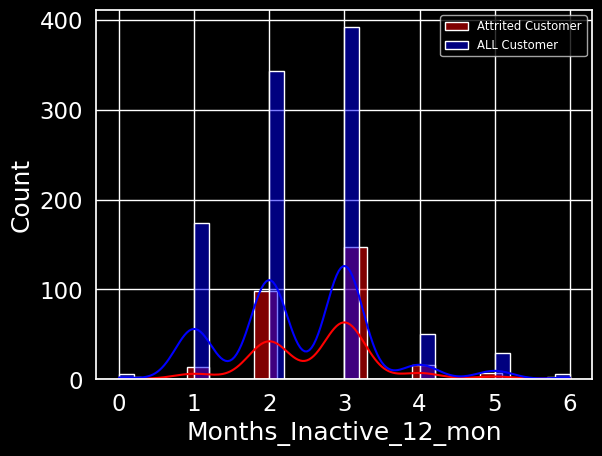

In [ ]:
# ▶ Months_Inactive_12_mon(비활성화 개월 수)에 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 어두운 배경 스타일 적용
plt.style.use(['dark_background'])

# 이탈고객의  분포
sns.histplot(high_risk[high_risk['Attrition_Flag'] == 'Attrited Customer']['Months_Inactive_12_mon'], color='red', kde=True, label='Attrited Customer')

# 전체 고객의  분포
sns.histplot(high_risk['Months_Inactive_12_mon'], color='blue', kde=True, label='ALL Customer')

# 범례 표시
plt.legend(loc='upper right', fontsize='small')

# 그래프 보이기
plt.show()


In [ ]:
# np.where() : 조건에 따라 값을 반환하는 함수
import numpy as np

high_risk['Months_Inactive_12_mon_gp'] = np.where(
    high_risk['Months_Inactive_12_mon'] <= 2, 1,
    np.where(high_risk['Months_Inactive_12_mon'] <= 4, 2, 3)
)

high_risk[['Months_Inactive_12_mon', 'Months_Inactive_12_mon_gp']]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Months_Inactive_12_mon,Months_Inactive_12_mon_gp
21,3,2
51,3,2
68,2,1
95,4,2
108,0,1
...,...,...
8550,3,2
8551,3,2
8553,3,2
8592,3,2


In [ ]:
# ▶ 구간화에 따른 고객 이탈율
num_val='Months_Inactive_12_mon_gp'

# ▶ 1단계
df_tran = pd.DataFrame(high_risk.groupby([num_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = num_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot



,Months_Inactive_12_mon_gp,Attrited Customer,Existing Customer,ratio
0,1,114.0,409.0,21.8
1,2,163.0,279.0,36.9
2,3,10.0,25.0,28.6


Dependent_count 구간화를 통한 이탈율 확인

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


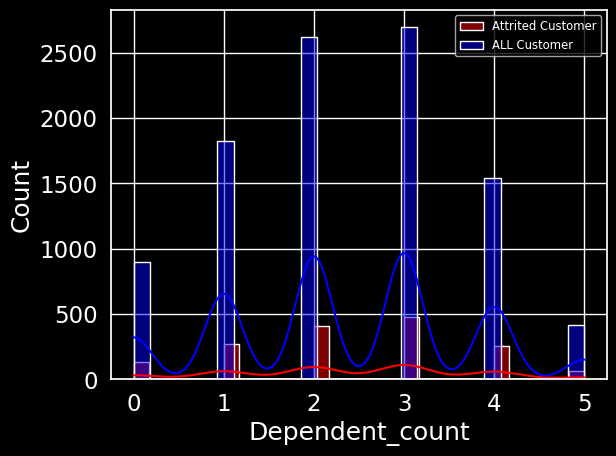

In [ ]:
# ▶ Dependent_count(부양가족 수)에 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 어두운 배경 스타일 적용
plt.style.use(['dark_background'])

# 이탈고객의 분포
sns.histplot(df_risk_classification[df_risk_classification['Attrition_Flag'] == 'Attrited Customer']['Dependent_count'], color='red', kde=True, label='Attrited Customer')

# 전체 고객의  분포
sns.histplot(df_risk_classification['Dependent_count'], color='blue', kde=True, label='ALL Customer')

# 범례 표시
plt.legend(loc='upper right', fontsize='small')

# 그래프 보이기
plt.show()


In [ ]:
# np.where() : 조건에 따라 값을 반환하는 함수
import numpy as np

df_risk_classification['Dependent_count_gp'] = np.where(
    df_risk_classification['Dependent_count'] <= 2, 1,
    np.where(df_risk_classification['Dependent_count'] <= 4, 2, 3)
)

df_risk_classification[['Dependent_count', 'Dependent_count_gp']]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Dependent_count,Dependent_count_gp
0,3,2
1,5,3
2,3,2
3,4,2
4,3,2
...,...,...
10122,2,1
10123,2,1
10124,1,1
10125,2,1


In [ ]:
# ▶ 구간화에 따른 고객 이탈율
num_val='Dependent_count_gp'

# ▶ 1단계
df_tran = pd.DataFrame(df_risk_classification.groupby([num_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()
df_tran.head(5)

# ▶ 2단계
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = num_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열
# ▶ 3단계
df_pivot = df_pivot.reset_index()
df_pivot.columns.names=['']

# ▶ 4단계
df_pivot['ratio'] =   round((df_pivot.iloc[:,1] / (df_pivot.iloc[:,1] + df_pivot.iloc[:,2])) * 100,1)
df_pivot



,Dependent_count_gp,Attrited Customer,Existing Customer,ratio
0,1,807.0,4531.0,15.1
1,2,731.0,3504.0,17.3
2,3,63.0,355.0,15.1


40~59세 까지의 이탈율과 평균 부양가족수

In [ ]:
import pandas as pd

# 예제 데이터프레임 생성 (실제 데이터프레임을 사용해야 합니다)
# df_risk_classification = pd.read_csv('path_to_your_data.csv')

num_val = 'Customer_Age_gp'

# ▶ 1단계: 고객 나이 구간화 및 이탈 여부에 따른 그룹화
df_tran = pd.DataFrame(df_risk_classification.groupby([num_val, 'Attrition_Flag'])['CLIENTNUM'].count()).reset_index()

# ▶ 1.1단계: 고객 나이 구간화 및 부양가족수의 평균 계산
df_dep_mean = pd.DataFrame(df_risk_classification.groupby(num_val)['Dependent_count'].mean()).reset_index()
df_dep_mean.columns = [num_val, 'mean_dependent_count']

# ▶ 2단계: 피벗 테이블 생성
df_pivot = pd.pivot_table(df_tran,               # 피벗할 데이터프레임
                      index = num_val,           # 행 위치에 들어갈 열
                      columns = 'Attrition_Flag',         # 열 위치에 들어갈 열
                      values = 'CLIENTNUM')   # 데이터로 사용할 열

# ▶ 3단계: 인덱스를 초기화하고 열 이름 변경
df_pivot = df_pivot.reset_index()
df_pivot.columns.names = ['']

# ▶ 4단계: 이탈율 계산
df_pivot['ratio'] = round((df_pivot['Attrited Customer'] /
                           (df_pivot['Attrited Customer'] + df_pivot['Existing Customer'])) * 100, 1)

# ▶ 5단계: 부양가족수 평균 추가
df_dep_mean['mean_dependent_count'] = round(df_dep_mean['mean_dependent_count'], 1)
df_pivot = pd.merge(df_pivot, df_dep_mean, on=num_val, how='left')

# 결과 출력
df_pivot


,Customer_Age_gp,Attrited Customer,Existing Customer,ratio,mean_dependent_count
0,1,338.0,2033.0,14.3,2.0
1,2,1205.0,6012.0,16.7,2.5
2,3,58.0,345.0,14.4,0.5


![부양가속수.png](attachment:daa0a098-5c3e-4959-b08c-b7bcd065fecd.png)

# 인사이트

1. 캐시백 이벤트 & 1달간 미결제 고객에게 기프티콘 발송하여 결제유도 & 특정금액 이상 결제시 이벤트 진행

    ▶ Months_Inactive_12_mon 비활성화 개월수가 3개월이 경과한 시점에 고객들이 이탈활 확률이 비교적 높으므로 해당 개월수동안 사용기록없는 고객 선별
    
    ▶ 활성상태 유지 목적
   
    ▶ 3개월 기준으로 비활성화 되기때문에 2개월마다 프로모션 제공
   

2. 연령별 마케팅

   ▶연령별로 은행 서비스에 대한 필요가 다르므로, 분석 결과에 따른 차별화된 마케팅 전략 필요

    1) 젊은 고객 (20대 ~ 30대) - 디지털 편의성 강화 / - 금융 교육 프로그램 / - 일상과 연계된 리워드 프로그램
    
    ▶ avg_open_to_buy이 많이 남아있으면 이탈율이 높다.

    2) 중년 고객 (40대 ~ 50대) - 투자 및 재무 계획 지원 / - 고급 서비스 및 맞춤형 상품 / - 가족 중심 마케팅
    
    ▶40대,50대 고객의 이탈율이  약 17%
    
    ▶dependent_count 이 3 이상인 고객의 이탈율 약17%
